# Behavioral Cloning Project

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report (This is that written report.)

## Rubric Points
** Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/432/view) individually and describe how I addressed each point in my implementation.  **

---
### Files Submitted & Code Quality

#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode

My project includes the following files:
* model.py containing the script to create and train the model
* drive.py for driving the car in autonomous mode
* model.h5 containing a trained convolution neural network 
* writeup_report.md - summary of results
* model.ipynb - source document for the writeup.md and model.py. 

#### 2. Submission includes functional code
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing 
```sh
python drive.py model.h5
```

#### 3. Submission code is usable and readable

The model.py file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

## Overall process

1. Create training data by driving around the track.
2. Design and test different model archetectures.
3. Tune model parameters.
4. Test model on track. 


## 1. Creation of the Training Set & Training Process

To capture training data I drop around track 1 three times using center lain driving. To help the car recover if it got off the track I collected training data driving on the left and right side of the track for a total of 6 laps. To create even more training data I drove the same center, left and right courses going in the reverse direction. 

Here is the code I used to visualize the collected training data.

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
from PIL import Image
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#Constants
DATA_PATH = '/home/ubuntu/udacity_projects/P3_behavioral_cloning/driving_data/'
SIDE_CAMERA_ADJUSTMENT = .06
SIDE_DRIVING_ADJUSTMENT = .3

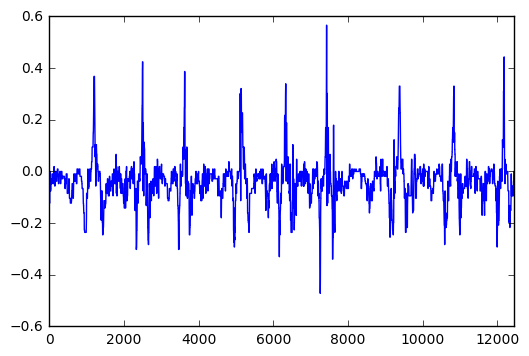

In [3]:
def convert_paths(df, folder):
    #convert paths of datalog to those on local computer
    for i in range(len(df)):
        for col in ['img_center', 'img_left', 'img_right']:
            file = df.ix[i, col].split('/')[-1]
            img_path = os.path.join(folder, 'IMG', file)
            df.ix[i, col] = img_path
    return df

def load_datasets(folder_nums):
    #load datasets from multiple folders
    dataframes = []
    for num in folder_nums:
        folder = os.path.join(DATA_PATH, 'track_'+str(num))
        df = pd.read_csv(os.path.join(folder, 'driving_log.csv'))
        df.columns = ['img_center', 'img_left', 'img_right', 'steering', 'throttle', 'break', 'speed']
        df = convert_paths(df, folder)
        dataframes.append(df)
    df = pd.concat(dataframes)
    return df

#Load the datasets.
df_center = load_datasets([11])
df_left = load_datasets([13])
df_right = load_datasets([12])

df = pd.concat([df_center, df_left, df_right])
df = df.reset_index(drop=True)
df['steering'].plot()

Since I didn't want the car to go to drive on the side of track, I adjusted the training data where I drove on the side to have higher steering angles back toward the center of the track. The training data collected on the right side had an adjustment of + .3 and the left training data had an adjustment of -.3.

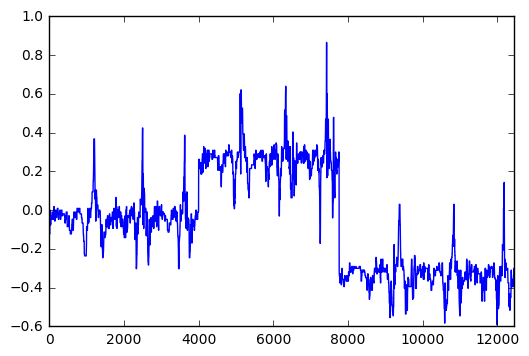

In [4]:
#Here we adjust the steering angles of the training data where I 
#drove on the side of the track. 
df_left['steering'] = df_left['steering'] + SIDE_DRIVING_ADJUSTMENT
df_right['steering'] = df_right['steering'] - SIDE_DRIVING_ADJUSTMENT
df = pd.concat([df_center, df_left, df_right])
df = df.reset_index(drop=True)
df['steering'].plot()

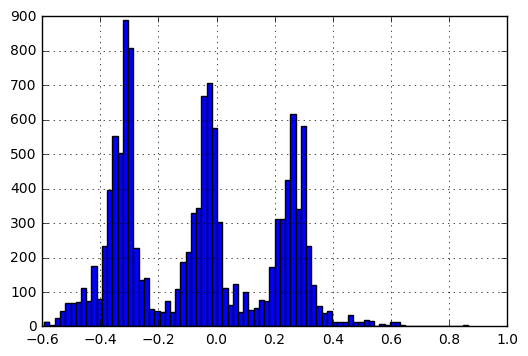

In [5]:
df['steering'].hist(bins=81)

In [6]:
#df_curves['steering'].hist(bins=81)

In [7]:
def get_data(df, row, img_col, steering_adjust):
    img_path = df[img_col][row]
    #print(img_path)
    img = Image.open(img_path)
    img_arr = np.array(img)
    raw_angle = df['steering'][row]
    #print('raw_angle ', raw_angle)
    angle = raw_angle + steering_adjust
    #print('adjusted angle', angle)
    return img_arr, angle

To prepare the data for training the neural network I used a generator to create batches of image and steering angle pairs. For each data row the generator selects a random camera angel (left,center or right) and adjustes the steering angel to bring the car back to center and flips the image horizontally and reverses the steerign angle half the time to create more data inputs to help avoid over fitting. 

In [8]:
def data_gen(df, batch_size=64, sample_ix=None):
    arg_choices = [
                    {'img_col': 'img_center', 'adjust': 0.0},
                    {'img_col': 'img_left',   'adjust': SIDE_CAMERA_ADJUSTMENT},
                    {'img_col': 'img_right',  'adjust': -SIDE_CAMERA_ADJUSTMENT},]    

    while True:
        images=[]
        angles=[]
        rows = sample_ix[:batch_size]
        for i in rows:
            #randomly select a camera angle.
            args = random.choice(arg_choices)
            #get the numpy array and adjust the steering angle.
            img, angle = get_data(df, i, args['img_col'], steering_adjust=args['adjust'])

            #half the time flip the steering angle. 
            flip = random.randint(0, 1)
            if flip == 1:
                img = np.fliplr(img)
                angle = -angle
                
            images.append(img)
            angles.append(angle)

        #create the batch of images and steering images for keras.
        X_train = np.array(images)
        y_train = np.array(angles)
        yield X_train, y_train

To avoid overfitting we split the data set into a training set that we use to train the model and a validation set that the model has never seen that is used to test if the model has learned something other than memorizing the input data. 

In [9]:
#create and index of the data rows
df = df.reset_index(drop=True)
n = len(df)
sample_ix = list(range(n))
random.shuffle(sample_ix)

#separate index into train and validation
train_n = round(n * .8)
train_ix = sample_ix[:train_n]
val_ix = sample_ix[train_n:]

#create data generators with those indexes
train_gen = data_gen(df, sample_ix=train_ix)
val_gen = data_gen(df, sample_ix=val_ix)

Here are some examples of images and steering angles used in the trainign data.

-0.12603774


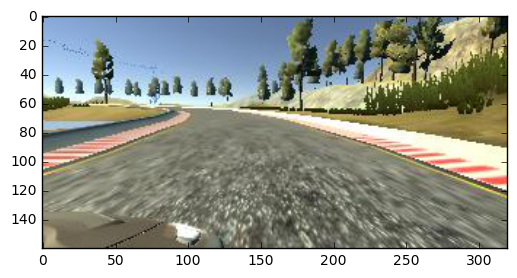

In [10]:
X, y = next(train_gen)
i = 0
plt.imshow(X[i])
print(y[i])

-0.06


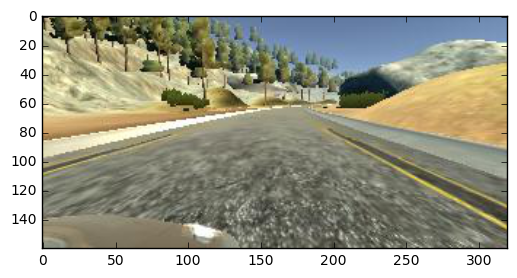

In [11]:
i = 2
plt.imshow(X[i])
print(y[i])

## Build a model

Now that we have a data pipeline we want to build a network archetecture that will learn how to drive. To do this I used a similar archetecture as I've used on my Donkey Car that I race in DIY Robocars races. 

It has Several layers of convolutions and dense layers with a single output for the angle. Some of the characteristics of model include.
* It has elu and relu activation functions to introduce non-linearity. 
* The convolutions use strides that are longer in the X dimension.
* To avoid over fitting I use L2 regularizers on most of the layers. 
* It uses an adam optimizer since this has become the standard for Convlution based nets.

In [12]:
import keras
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, AveragePooling2D, MaxPool2D, SimpleRNN, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D, Lambda
from keras.regularizers import l2

def build_model1():
    '''
    Function to create models with convolutional heads and dense tails.
    Accepts dictionaries defining the conv and dense layers.
    '''

    img_in = Input(shape=(160, 320,3), name='img_in')
    x = Lambda(lambda x: (x / 255.0) - 0.5)(img_in)
    x = Cropping2D(cropping=((60, 20), (0, 0)))(x)
    #x = AveragePooling2D(2,2)(x)
    x = Convolution2D(16, (4,4), strides=(3,4), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(32, (4,4), strides=(1,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(48, (4,4), strides=(1,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Flatten(name='flattened')(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.002))(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.002))(x)
    x = Dense(10, activation='relu', kernel_regularizer=l2(0.002))(x)
    angle = Dense(1)(x)
    
    model = Model(inputs=[img_in], outputs=[angle])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = build_model1()

Using TensorFlow backend.


Here is the structure of the model and the number of parameters.

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 80, 16)        784       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 39, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 18, 48)        24624     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 16, 64)        27712     
__________

To train the net I feed use the training and validation generator to train and test the network. Callbacks are used to save the model with the lowest validation error and stop when the validation error stops improving. 

In [14]:
#checkpoint to save model after each epoch
save_best = keras.callbacks.ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, 
                                      save_best_only=True, mode='min')

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0005, patience=2, 
                                     verbose=1, mode='auto')

callbacks_list = [save_best, early_stop]

model.fit_generator(train_gen, 100, epochs=50, validation_data=val_gen, 
                    callbacks=callbacks_list, validation_steps=40)

Epoch 1/50
100/100 [==============================] - 32s - loss: 0.5319 - val_loss: 0.4068
Epoch 2/50
100/100 [==============================] - 16s - loss: 0.2881 - val_loss: 0.2833
Epoch 3/50
100/100 [==============================] - 16s - loss: 0.1966 - val_loss: 0.2093
Epoch 4/50
100/100 [==============================] - 16s - loss: 0.1438 - val_loss: 0.1693
Epoch 5/50
100/100 [==============================] - 16s - loss: 0.1118 - val_loss: 0.1482
Epoch 6/50
100/100 [==============================] - 16s - loss: 0.0921 - val_loss: 0.1321
Epoch 7/50
100/100 [==============================] - 16s - loss: 0.0755 - val_loss: 0.1210
Epoch 8/50
100/100 [==============================] - 16s - loss: 0.0656 - val_loss: 0.1122
Epoch 9/50
100/100 [==============================] - 16s - loss: 0.0587 - val_loss: 0.1059
Epoch 10/50
100/100 [==============================] - 16s - loss: 0.0540 - val_loss: 0.1015
Epoch 11/50
100/100 [==============================] - 16s - loss: 0.0495 - val

## Future Improvements.

Unfortunately I'm rushed to finish my last homeworks assigments so I'm not experimenting as much as I'd like. Later I'd like to come back on try the following things.

* Use image augmentation (blur, shift, ..) to make the model more robust.
* train the throttle so the car slows down on the corners and speeds up on the straights.
* See how small the model could get and still work. 